# Identifying sentences that convey meaningful semantic relation between entities within the sentence - Exploratory Data Analysis (EDA)


The objective of this notebook is to present a brief exploratory data analysis (EDA) of the sampled dataset that will be later used.

In [151]:
from IPython.display import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import powerlaw


## Part 1: Named Entities EDA

The Named Entities analysis was conducted during the dataset generation.
The distribution of named entity occurances, along with their corresponding labels, follows a heavy-tail distibution pattern, as can be seen below:

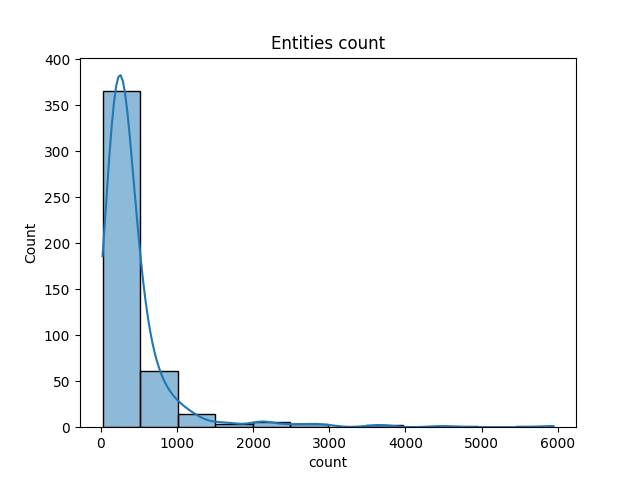

In [98]:
Image(filename='./sampled_sentences_stats/entities_count.png')

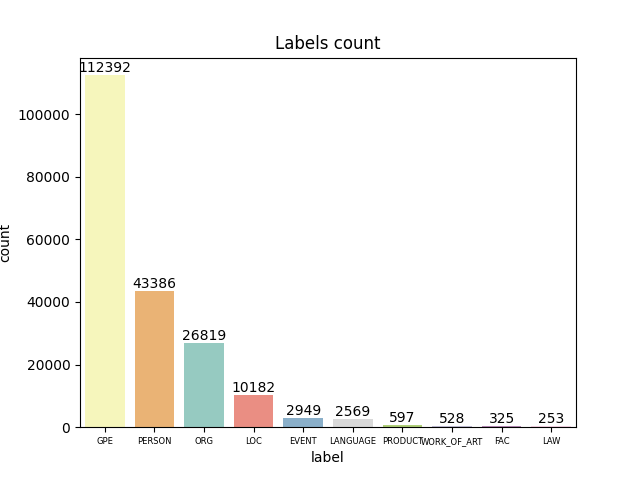

In [99]:
Image(filename='./sampled_sentences_stats/labels_count.png')

We can see that Named-entities pairs follow a heavy-tail distibution as well:

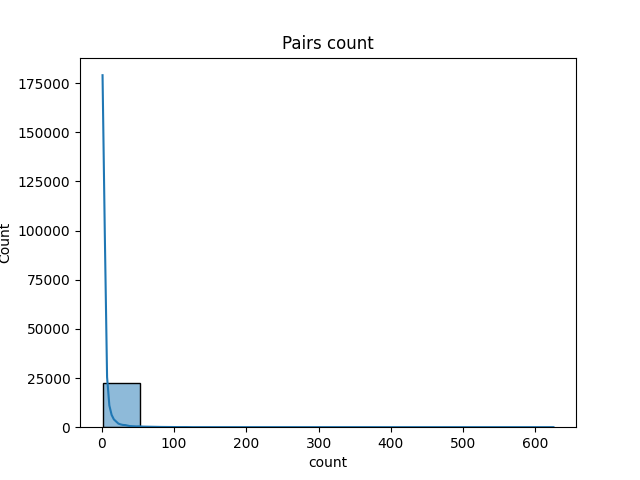

In [100]:
Image(filename='./sampled_sentences_stats/pairs_count.png')

The occurrences of the paired labels can be visualized using a heatmap. For instance, it can be observed that pairs labeled as GPE-GPE (geopolitical entities) are the most common.

Other frequent combinations include: GPE-LOC (geopolitical entity - location), GPE-ORG (geopolitical entity - organization), GPE-PERSON, LOC-LOC (location - location), ORG-ORG (organization - organization), ORG-PERSON, and PERSON-PERSON.

*Notes:*

* In this context, each pair is counted twice due to the symmetric nature of the relation. For example, a pair consisting of GPE and PERSON will be counted once as (GPE, PERSON) and then again as (PERSON, GPE).

* In the original dataset, there were more occurrences of the PERSON-PERSON relation compared to the GPE-GPE relation. However, in the sampled dataset, this relation is reversed. One possible explanation for this is that names of individual people are fewer by nature compared to names of places. As a result, fewer person named entities met the requirement of appearing more than 1000 times in the texts.


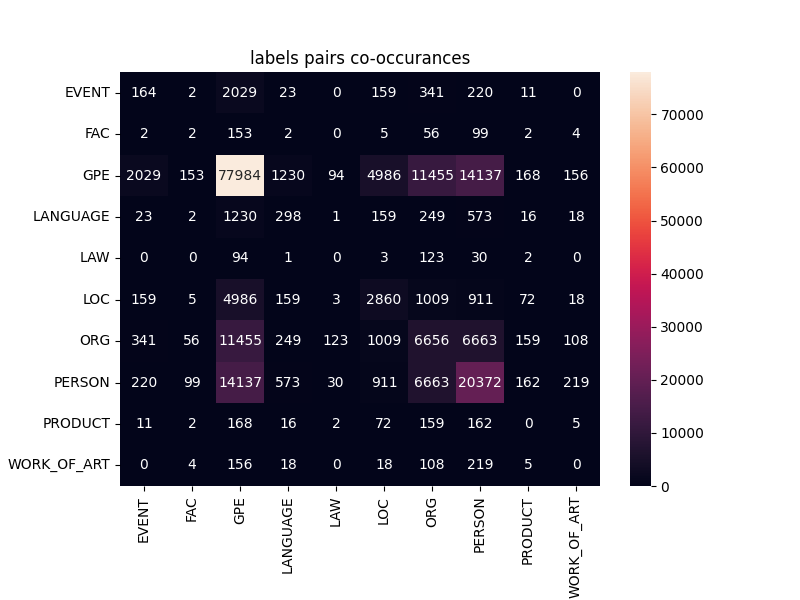

In [101]:
Image(filename='./sampled_sentences_stats/pairs_labels_count.png')

## Part 2: Exploring the Mutual Information (MI) Score

### Exploring the MI for the entire dataset

The mutual information (MI) analysis also reveals a clear power-law distribution. It is apparent that lower MI values occur frequently, indicating a lower level of relationship between the entities. Conversely, entities with a higher level of relationship are less common.

In [102]:
dataset_path = '../data/data.csv'
df = pd.read_csv(dataset_path)

In [103]:
df['mi_score'].describe()

count    1.000000e+05
mean     5.106924e-05
std      1.522974e-04
min      5.764400e-09
25%      3.477038e-07
50%      3.442040e-06
75%      3.025925e-05
max      1.185945e-03
Name: mi_score, dtype: float64

Text(0.5, 1.0, 'Mutial information distribution')

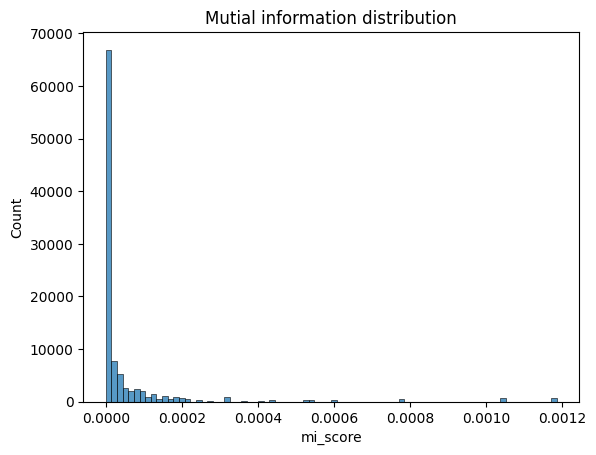

In [104]:
sns.histplot(data=df['mi_score'], kde=False, binrange=(min(df['mi_score']), max(df['mi_score'])), bins=80)
plt.title('Mutial information distribution')

### Estimating Probability Distribution for MI

To estimate the probability, we will fit the parameters of a power-law distribution:

In [161]:
def fit_powerlaw_dist(values):
    fit_params = powerlaw.fit(values)
    fitted_distribution = powerlaw(*fit_params)
    return fitted_distribution

def plot_fitted_dist(values, fitted_distribution, label, bins=80):
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(values, bins=bins, density=False, alpha=0.5, label=label)
    # Plot the fitted distribution using the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fitted_pdf = fitted_distribution.pdf(bin_centers)
    ax.plot(bin_centers, fitted_pdf, color='r', label='Fitted Power-law Distribution')

    plt.title(f'Histogram of {label}')
    plt.xlabel(label)
    plt.ylabel('Frequency')

    plt.legend()
    plt.show()

def create_fitted_precentiles(values, fitted_distribution):
    percentiles = np.arange(10, 110, 10)  # Generate an array from 10 to 100 in increments of 10
    data_percentiles = np.percentile(values, percentiles)
    distribution_precentiles = [fitted_distribution.ppf(p / 100) for p in percentiles]

    precentiles_df = pd.DataFrame({
        'Percentile': percentiles,
        'data percentiles': data_percentiles,
        'distribution precentiles': distribution_precentiles
    }).set_index('Percentile')

    return precentiles_df

def report_score_fitting(scores, score_name):
    fitted_dist = fit_powerlaw_dist(scores)
    plot_fitted_dist(scores, fitted_dist, score_name)
    print(create_fitted_precentiles(scores, fitted_dist))


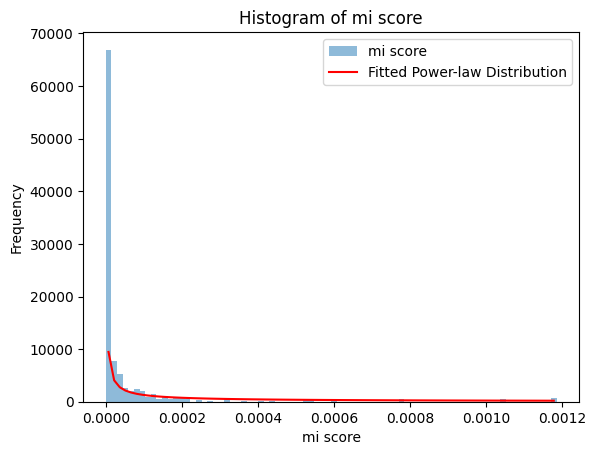

            data percentiles  distribution precentiles
Percentile                                            
10              4.707982e-08              6.937012e-08
20              2.004534e-07              1.264000e-06
30              5.677300e-07              7.217316e-06
40              1.436818e-06              2.489592e-05
50              3.442040e-06              6.506844e-05
60              8.299842e-06              1.426632e-04
70              1.944285e-05              2.770659e-04
80              4.489496e-05              4.923777e-04
90              1.190581e-04              8.176441e-04
100             1.185945e-03              1.287062e-03


In [162]:
report_score_fitting(df['mi_score'], 'mi score')

### Pairs with highest and lowest MI score

In [107]:
sorted_df = df.sort_values(by='mi_score', ascending=False)

The 5 pairs with highest MI score:

In [108]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

2250619 Mulder PERSON Scully PERSON 0.00119 Mulder is a believer in the paranormal, while the skeptical Scully has been assigned to debunk his work.
1167625 Mulder PERSON Scully PERSON 0.00119 When Mulder and Scully travel to Iowa and meet the Morrises, Mulder observes Kevin writing down binary code on a piece of paper; Kevin claims they are coming from static on a television screen.
1167633 Scully PERSON Mulder PERSON 0.00119 On his person, they find a note in his wallet that eventually leads Scully and Mulder to conclude that it was Tessa, not Ruby, who was pregnant.
1167637 Mulder PERSON Scully PERSON 0.00119 A motorcycle gang appears, and as Mulder hurries to rescue Kevin from their wake, Scully discovers Ruby nearby.
1167651 Scully PERSON Mulder PERSON 0.00119 Chris Carter felt the episode's highlights were the ending and the realization by Scully that Mulder may not be a crackpot, feeling it was very important to the show in establishing its point of view.


The 5 pairs with lowest MI score:

In [109]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.mi_score:.5f} {s.sent}')

2604856 Moon PERSON Mitchell PERSON 0.00000 During an Inside Soap feature on the Moon brothers vs the Mitchell brothers, Kate Woodward said "Two sexy brothers to shake up Albert Square?
1453937 Barcelona GPE YouTube ORG 0.00000 During the 2010 Sant Jordi festivities in Barcelona, the (350 +) staff in one of the main buildings of the Polytechnic University of Catalonia used the ostensibly massive amounts of free time available to them to perform a notorious lip dub of the song that reached over 150000 views on YouTube.
966689 Burns PERSON Love WORK_OF_ART 0.00000 Mr. Burns himself has been involved with several women and in "A Hunka Hunka Burns in Love", Smithers is noticeably disgusted when Mr. Burns starts looking for a female companion.
234419 Lucas PERSON Bush PERSON 0.00000 Despite Lucas' insistence to the contrary, The Seattle Times concluded, "Without naming Bush or the Patriot Act, it's all unmistakable no matter what your own politics may be."
2687269 Stewart PERSON Yankees ORG

### Exploring the MI for each labels-pair

I decided to display only the top 8 label pairs in the dataset for mutual information (MI) analysis. As expected, we often observe a power-law distribution, with an additional cluster representing the pairs that frequently appeared together.

In [110]:
def plot_type_mi_hist_plot(df, type1, type2, bins='auto'):
    df1 = df[( (df['label1'] == type1) & (df['label2'] == type2) ) | ( (df['label2'] == type1) & (df['label1'] == type2) )]
    sns.histplot(data=df1['mi_score'], kde=False, bins=bins)
    plt.title(f'Mutial information distribution for labels: {type1}-{type2}')

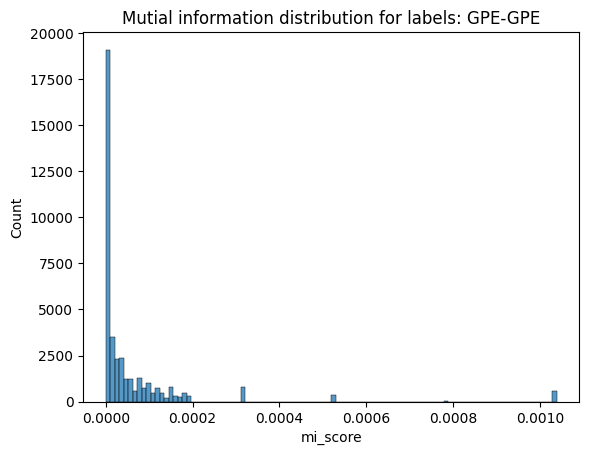

In [111]:
plot_type_mi_hist_plot(df, 'GPE', 'GPE', bins=100)

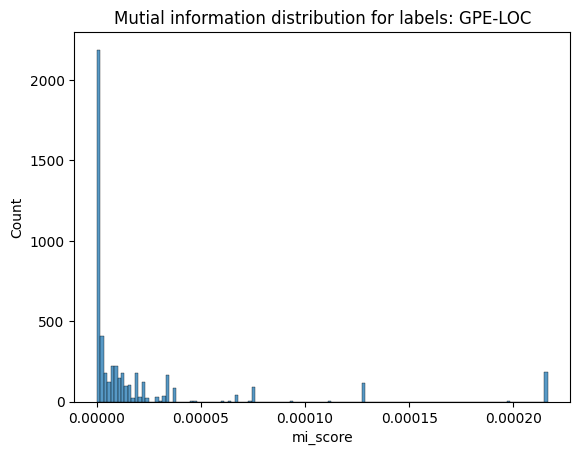

In [112]:
plot_type_mi_hist_plot(df, 'GPE', 'LOC')

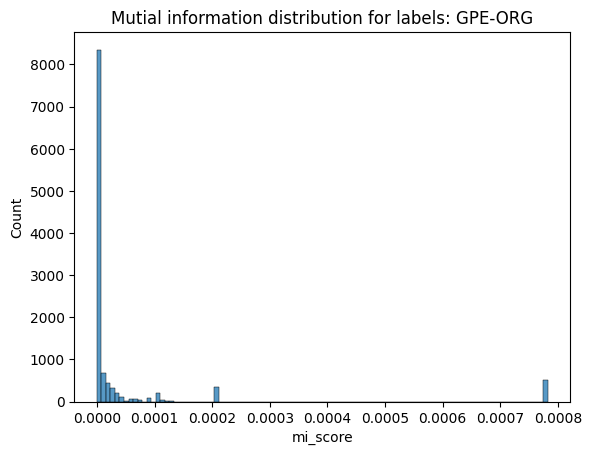

In [113]:
plot_type_mi_hist_plot(df, 'GPE', 'ORG', bins=100)

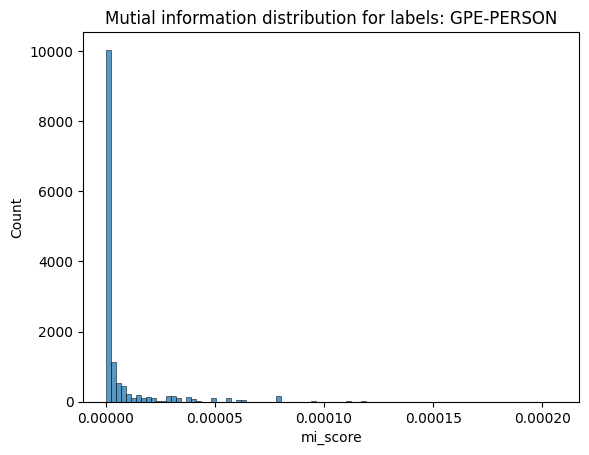

In [114]:
plot_type_mi_hist_plot(df, 'GPE', 'PERSON', bins=90)

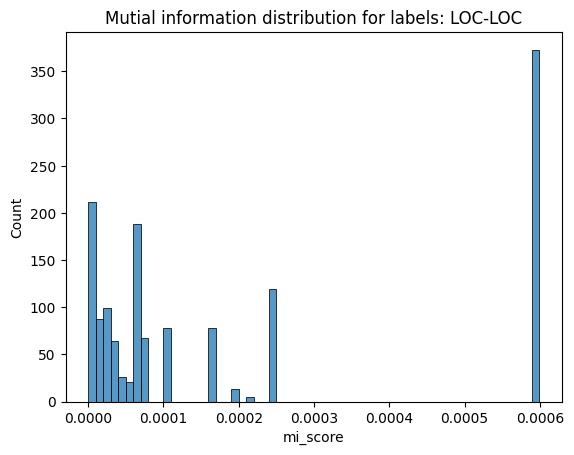

In [115]:
plot_type_mi_hist_plot(df, 'LOC', 'LOC', bins=60)

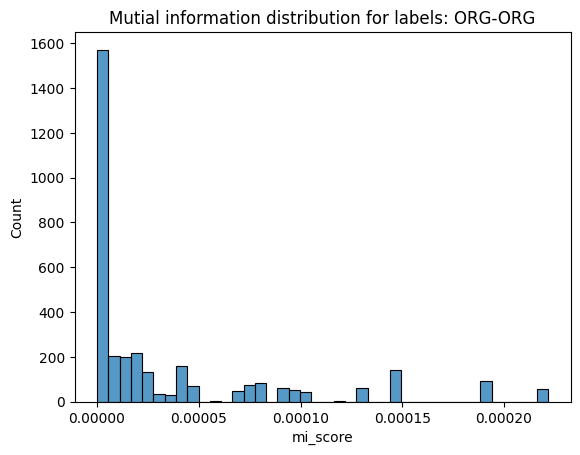

In [116]:
plot_type_mi_hist_plot(df, 'ORG', 'ORG')

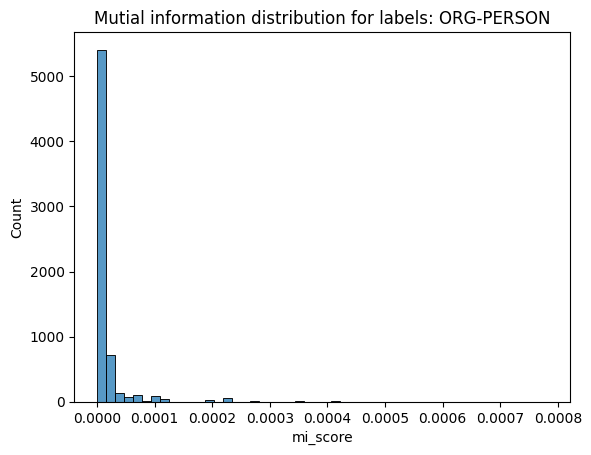

In [117]:
plot_type_mi_hist_plot(df, 'ORG', 'PERSON', bins=50)

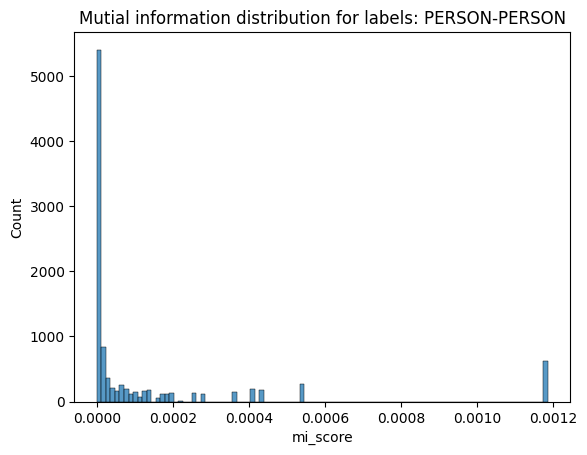

In [118]:
plot_type_mi_hist_plot(df, 'PERSON', 'PERSON', bins=100)

## Part 3: Exploring the Pointwise Mutual Information (PMI) Score

### Exploring the PMI for the entire dataset

When the PMI value is positive, it means that two named entities are likely to appear together more often than by chance. Since the highest PMI score is 0, we can say that in general, named entities are more likely to appear separately rather than together.

Text(0.5, 1.0, 'PMI distribution')

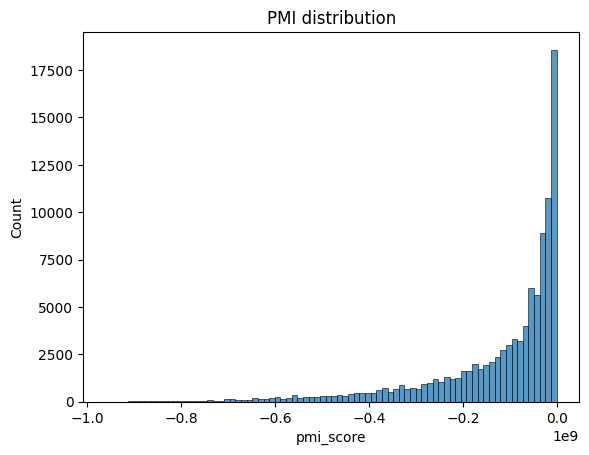

In [131]:
sns.histplot(data=df['pmi_score'], kde=False, binrange=(min(df['pmi_score']), max(df['pmi_score'])), bins=80)
plt.title('PMI distribution')

In [120]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

In [140]:
print(f"min pmi score: {min(df['pmi_score'])}, max pmi score: {max(df['pmi_score'])}")
print(f"pmi range: {max(df['pmi_score']- min(df['pmi_score']))}")

min pmi score: -960053415.0455084, max pmi score: -909664.7128966372
pmi range: 959143750.3326118


### Pairs with highest and lowest MI score

In [218]:
sorted_df = df.sort_values(by='pmi_score', ascending=False)

In [ ]:
The 5 pairs with highest PMI score:

In [219]:
for index, s in sorted_df.head(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

2466717 US GPE the United States GPE -909664.7128966372 The U.S., potentially the largest market for Brazilian ethanol imports, currently imposes a tariff on Brazilian ethanol of US $0.54 per gallon in order to encourage domestic ethanol production and protect the budding ethanol industry in the United States.
1368357 the United States GPE US GPE -909664.7128966372 Van Zandt, though he personally favored annexation by the United States, was not authorized to entertain any overtures from the US government on the subject.
1100754 US GPE the United States GPE -909664.7128966372 According to the Economist Intelligence Unit in 2011, "[I] f the [euro area] is treated as a single entity, its [economic and fiscal] position looks no worse and in some respects, rather better than that of the US or the UK" and the budget deficit for the euro area as a whole is much lower and the euro area's government debt / GDP ratio of 86% in 2010 was about the same level as that of the United States. "
667219 

Let's examine 'US' and 'the United States' as the pair with top PMI score:

In [230]:
def get_coappearnce_count(df, ent1, ent2):
    return len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] == ent1)])

def get_separate_coappearnce_count(df, ent1, ent2):
    ent1_count = len(sorted_df[(df['ent1'] == ent1) & (sorted_df['ent2'] != ent2)]) + \
            len(sorted_df[(df['ent1'] != ent2) & (sorted_df['ent2'] == ent1)])
    ent2_count = len(sorted_df[(df['ent1'] != ent1) & (sorted_df['ent2'] == ent2)]) + \
            len(sorted_df[(df['ent1'] == ent2) & (sorted_df['ent2'] != ent1)])
    return ent1_count, ent2_count

ent1 = 'US'
ent2 = 'the United States'

print(f'co-apperances: {get_coappearnce_count(sorted_df,ent1, ent2)}')

ent1_appearance, ent2_appearance = get_separate_coappearnce_count(sorted_df, ent1, ent2)
print(f'{ent1} appeared withoud {ent2} {ent1_appearance} times')
print(f'{ent2} appeared withoud {ent1} {ent1_appearance} times')

co-apperances: 115


The 5 pairs with lowest PMI score:

In [221]:
for index, s in sorted_df.tail(5).iterrows():
    print(f'{s.sent_id} {s.ent1} {s.label1} {s.ent2} {s.label2} {s.pmi_score} {s.sent}')

84404 St. Louis GPE R & B ORG -931294038.0542214 Local St. Louis deejay Dave Dixon convinced Ike to send the tape to Juggy Murray, president of R & B label, Sue Records.
2148229 Warner Bros. ORG the Los Angeles Times ORG -946246318.951853 Because retailers had high demand for the film, Warner Bros. shipped to them nearly one million copies, which the Los Angeles Times noted as "a record for direct-to-video programs".
2071288 Lucas PERSON Saturn PERSON -953383969.5181468 Racing the Masked Man in search of these Needles, Lucas battles through a laboratory of chimeras, reunites with Kumatora and Duster, and meets Mr. Saturn.
1126231 R & B ORG Las Vegas GPE -954300313.6978532 With country put on the back burner, and soul and R & B left in Memphis, what was left was very classy, very clean white pop — perfect for the Las Vegas crowd, but a definite retrograde step for Elvis."
1221943 the Los Angeles Times ORG Minogue PERSON -960053415.0455084 Margaret Wappler from the Los Angeles Times comm

## Part 5: Exploring the correlation between PMI and MI

We can see that the correlation is low:

In [129]:
correlation = sorted_df['mi_score'].corr(sorted_df['pmi_score'])
print(f"Correlation between 'mi_score' and 'pmi_score': {correlation}")


Correlation between 'mi_score' and 'pmi_score': 0.11613868306758517


## Part 4: Exploring sentences length

<AxesSubplot: >

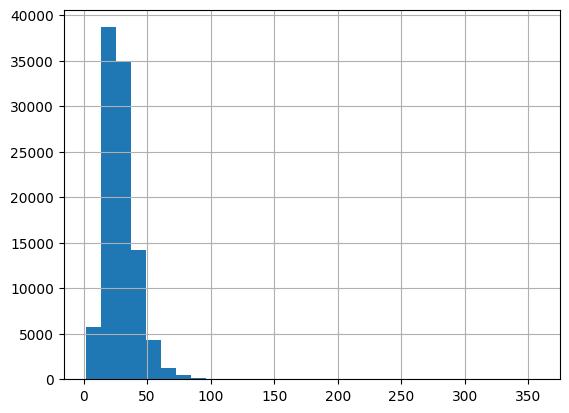

In [130]:
seq_len = [len(i.split()) for i in df['sent']]

pd.Series(seq_len).hist(bins = 30)